In [1]:
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import sys
sys.path.append('..')

'''
Exploratory data analysis for the tables {'cases', 'documents', 'points', 'services', 'topics'} dumped on oct 18th '21

Service - website, app, etc.
Point - a plain text highlight that summarizes as aspect of their policy. It is often a quote, but doesn't have to be, 
    e.g. "The terms for this service are easy to read". Each point is 1-1 with a Case.
Case - higher-level Service-agnostic patterns that Points exhibit. For example, "No third-party analytics or tracking platforms are used"
Topic - even higher-level patterns, that contain a handful of Cases. For example, "User Choice"
Document - crawled text from a Service

Foreign keys:
Service - user
Document - user, service
Topic - none
Case - topic
Point - user, service, case, document
'''

'\nExploratory data analysis for the tables {\'cases\', \'documents\', \'points\', \'services\', \'topics\'} dumped on 10/18/21\n\nService - website, app, etc.\nPoint - a plain text highlight that summarizes as aspect of their policy. It is often a quote, but doesn\'t have to be, \n    e.g. "The terms for this service are easy to read". Each point is 1-1 with a Case.\nCase - higher-level Service-agnostic patterns that Points exhibit. For example, "No third-party analytics or tracking platforms are used"\nTopic - even higher-level patterns, that contain a handful of Cases. For example, "User Choice"\nDocument - crawled text from a Service\n\nForeign keys:\nService - user\nDocument - user, service\nTopic - none\nCase - topic\nPoint - user, service, case, document\n'

In [2]:
VERSION = '181021'
cases = pickle.load(open(f'../data/cases_{VERSION}.pkl', 'rb'))
documents = pickle.load(open(f'../data/documents_{VERSION}.pkl', 'rb'))
points = pickle.load(open(f'../data/points_{VERSION}.pkl', 'rb'))
services = pickle.load(open(f'../data/services_{VERSION}.pkl', 'rb'))
topics = pickle.load(open(f'../data/topics_{VERSION}.pkl', 'rb'))

In [3]:
# Before we work with Services, it looks like there are deleted ones to remove
# We'll also want to remove related Documents and Points
print(services.status.value_counts())
deleted_service_ids = services[services.status == 'deleted'].id
services = services[~(services.status == 'deleted')].drop('status', axis=1)

documents = documents[~documents.service_id.isin(deleted_service_ids)]
points = points[~points.service_id.isin(deleted_service_ids)]

deleted    50
Name: status, dtype: int64


In [4]:
# inspect Services

services.info()
services.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4032 entries, 230 to 5150
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id                           4032 non-null   int64         
 1   name                         4032 non-null   object        
 2   url                          4032 non-null   object        
 3   created_at                   4032 non-null   datetime64[ns]
 4   updated_at                   4032 non-null   datetime64[ns]
 5   wikipedia                    3996 non-null   object        
 6   keywords                     302 non-null    object        
 7   related                      303 non-null    object        
 8   slug                         4020 non-null   object        
 9   is_comprehensively_reviewed  4032 non-null   bool          
 10  user_id                      1188 non-null   float64       
 11  rating                       4020 non-nul

,id,name,url,created_at,updated_at,wikipedia,keywords,related,slug,is_comprehensively_reviewed,user_id,rating
id,,,,,,,,,,,,
230,230,PayPal,"paypal.com,newsroom.paypal-corp.com",2018-01-16 15:26:06.469533,2021-03-25 03:19:24.571887,https://en.wikipedia.org/wiki/PayPal,,,paypal,True,NaN,E
440,440,pebble,pebble.com,2018-05-08 12:19:44.833708,2021-03-25 03:19:30.208894,None,,,pebble,False,NaN,N/A
225,225,Spotify,"spotify.com,spotifyforvendors.com,spotifyjobs.com",2018-01-16 15:26:06.332058,2021-03-25 03:19:30.801812,https://en.wikipedia.org/wiki/Spotify,,soundcloud,spotify,True,NaN,E
183,183,CouchSurfing,"couchsurfing.org,couchsurfing.com",2018-01-16 15:26:05.544807,2021-03-25 03:19:31.618318,https://en.wikipedia.org/wiki/CouchSurfing,,,couchsurfing,True,NaN,E
219,219,Instagram,"instagram.com,help.instagram.com,about.instagr...",2018-01-16 15:26:06.211757,2021-03-25 03:19:31.833924,https://en.wikipedia.org/wiki/Instagram,,,instagram,True,NaN,E


Text(0.5, 1.0, 'Services added over time')

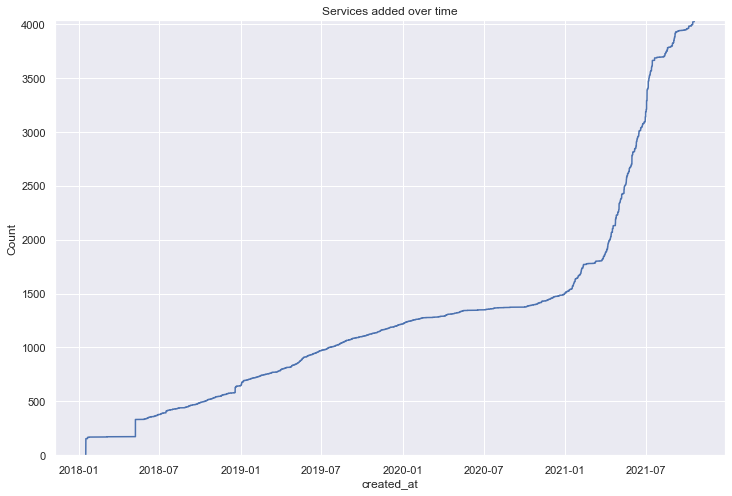

In [5]:
# How have the number of Services grown over time?
plt.figure(figsize=(12,8))
sns.ecdfplot(services, x='created_at', stat='count')
plt.title('Services added over time')

In [6]:
# How many have been comprehensively reviewed?
services.is_comprehensively_reviewed.value_counts()

False    3645
True      387
Name: is_comprehensively_reviewed, dtype: int64

/Users/evan/anaconda3/envs/docbot-server/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Service ratings')

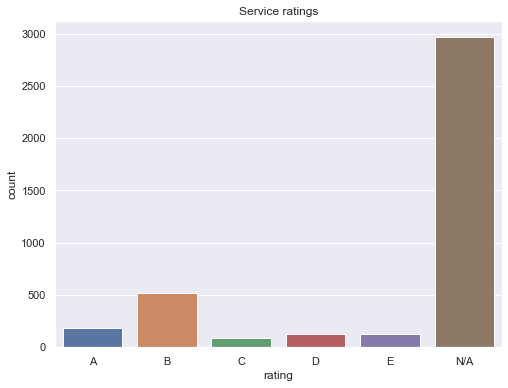

In [7]:
# What are they rated?
plt.figure(figsize=(8,6))
sns.countplot(services.rating, order=['A', 'B', 'C', 'D', 'E', 'N/A'])
plt.title('Service ratings')

In [8]:
# Like before, drop deleted Documents, and related Points
print(documents.status.value_counts())
deleted_document_ids = documents[documents.status == 'deleted'].id
documents = documents[~(documents.status == 'deleted')].drop('status', axis=1)
points = points[~points.document_id.isin(deleted_document_ids)]

deleted    23
Name: status, dtype: int64


In [9]:
# inspect Documents

documents.text = documents.text.replace('', np.nan)
documents.info()
documents.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8012 entries, 1149 to 9224
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              8012 non-null   int64         
 1   name            8012 non-null   object        
 2   url             8012 non-null   object        
 3   xpath           7719 non-null   object        
 4   text            6516 non-null   object        
 5   created_at      8012 non-null   datetime64[ns]
 6   updated_at      8012 non-null   datetime64[ns]
 7   service_id      8012 non-null   int64         
 8   reviewed        227 non-null    object        
 9   user_id         3721 non-null   float64       
 10  crawler_server  3947 non-null   object        
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 751.1+ KB


,id,name,url,xpath,text,created_at,updated_at,service_id,reviewed,user_id,crawler_server
id,,,,,,,,,,,
1149,1149,social.privacytools.io Privacy Policy,https://social.privacytools.io/terms,/html/body/div/div[2]/div/div[1]/div,\nPrivacy <p>Please review our privacy stateme...,2019-04-06 02:39:01.465351,2020-12-14 19:29:56.243824,1472,None,NaN,None
2169,2169,Privacy Policy,https://www.billtrack50.com/privacy-policy,None,"&lt;iframe src=""https://www.googletagmanager.c...",2019-11-27 20:21:01.498279,2020-12-14 23:27:23.768990,2022,None,3480.0,None
2123,2123,Privacy Policy,https://mrichard333.com/Privacy-policy,,<ul>\n<li>Home</li>\n<li>Videos</li>\n<li>Con...,2019-11-11 16:04:52.941473,2020-12-15 00:51:52.643832,1728,None,3877.0,None
3719,3719,Privacy Policy,https://www.savvasrealize.com/privacy/corporat...,/html/body/main/div/section/div/div/div[1],Privacy Policy We recently updated our Privac...,2021-01-21 11:15:08.988939,2021-01-24 08:49:24.411559,2619,None,20760.0,None
7,7,Terms of Service,https://help.habbo.com/hc/en-us/articles/22164...,//div[@class='content-body article-body'],<p>\n<strong>Habbo.com - Terms of Service</st...,2018-07-17 10:11:40.691179,2020-12-11 14:20:59.218294,292,True,NaN,None


In [10]:
# Most common Document names
documents.name.value_counts().head(15)

Privacy Policy          2119
Terms of Service         699
Terms of Use             450
Cookie Policy            249
Terms and Conditions     230
Privacy Policy           175
Terms                    109
Privacy policy            82
 Privacy Policy           79
Privacy Statement         71
Terms & Conditions        69
Privacy Notice            59
Privacy                   55
PRIVACY POLICY            37
Terms of use              36
Name: name, dtype: int64

In [11]:
# How many docs have no Points? Turns out, most of them
len(set(documents.id) - set(points.document_id))

5744

In [14]:
# In what languages are the docs?
from langdetect import detect
from langdetect import DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
DetectorFactory.seed = 0

def detect_lang(text):
    if text is None or pd.isnull(text) or text == '':
        return None
    try:
        return detect(text)
    except LangDetectException:
        return None

documents['lang'] = documents.apply(lambda doc: detect_lang(doc.text), axis=1)
documents.lang.value_counts()

en       6028
de        112
fr        102
nl         42
es         34
zh-cn      31
it         26
ru         24
ca         13
pt         11
ro          9
ko          9
ja          6
no          5
tr          5
da          4
bg          4
et          4
el          4
id          3
pl          3
cs          3
fi          2
sv          2
hu          2
sw          1
cy          1
hr          1
tl          1
ar          1
Name: lang, dtype: int64

count      6516.000000
mean      22345.182320
std       30960.731888
min           1.000000
25%        5988.000000
50%       14810.000000
75%       29565.000000
max      830858.000000
Name: doc_len, dtype: float64


Text(0.5, 1.0, 'Document length (num characters)')

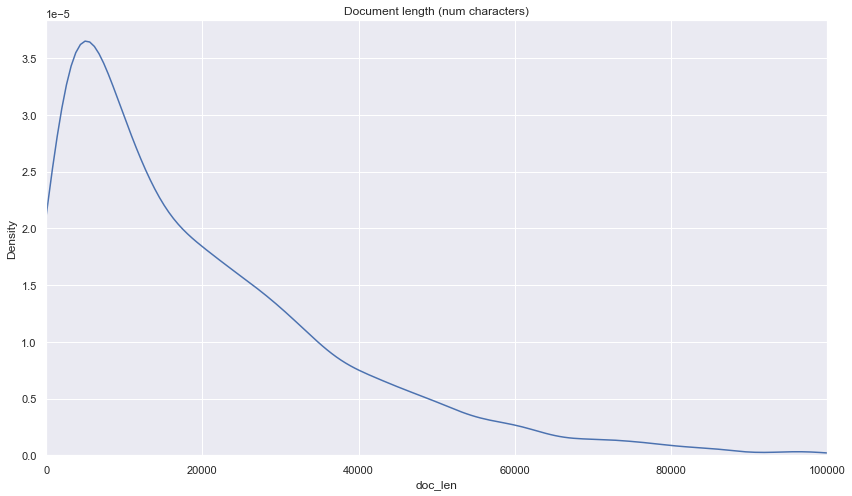

In [17]:
# Document lengths
documents['doc_len'] = documents.text.str.len()
print(documents.doc_len.describe())

# Graph the density (with outliers filtered so the x-axis is not stretched)
fig, ax = plt.subplots(figsize=(14, 8))
ax.set_xlim((0,100000))
sns.kdeplot(documents.doc_len[documents.doc_len < 100000], ax=ax)
plt.title('Document length (num characters)')

In [18]:
# Not sure what `reviewed` is based on, but most values are null/NaN
documents.reviewed.value_counts()

True     152
False     75
Name: reviewed, dtype: int64

In [19]:
documents.crawler_server.value_counts()

eu            2621
us            1045
nosypeeper      85
floppy          84
atlas           30
avidreader      24
arachne         19
whale           15
james           14
dmitri          10
Name: crawler_server, dtype: int64

In [20]:
# Do a join to attach Service info to Documents
documents = pd.merge(documents, services, left_on='service_id', right_index=True, suffixes=['_doc', '_service'])

In [21]:
# Most Services have 1 or 2 documents, but some have a lot more
print(f"Documents per Service stats:\n{documents.service_id.value_counts().describe()}")
documents.groupby(['service_id', 'name_service']).size().sort_values(ascending=False).head(15)

Documents per Service stats:
count    3753.000000
mean        2.134825
std         1.562638
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max        26.000000
Name: service_id, dtype: float64


service_id  name_service                       
190         Amazon                                 26
3850        bunq                                   23
2887        Albertsons Companies,(Subsidiaries)    23
3133        SailPoint                              22
4027        Sympla                                 21
1559        HERE Technologies | HERE               21
1448        TikTok                                 17
3918        Optimum                                15
230         PayPal                                 14
2308        Rakuten                                14
3938        Fred Meyer                             12
3917        Rise Broadband                         12
312         Stack Overflow                         12
1566        Intercom                               11
186         Flickr                                 11
dtype: int64

In [22]:
# What are the Documents that cause these to be outliers? (replace service_id with one of the above. They are all legit AFAICT)
documents[documents.service_id == 2887][['name_doc', 'url_doc']]

,name_doc,url_doc
id,,
4452,HIPAA NOTICE OF PRIVACY PRACTICES,https://www.albertsonscompanies.com/about-us/o...
4458,ACME Markets Language Assistance Services,https://www.acmemarkets.com/content/dam/pharma...
4459,Coupon Policy,https://www.theunitedfamily.com/coupon-policy
4460,Rewards Terms And Conditions,https://www.theunitedfamily.com/rewards/terms-...
4461,Rewards,https://www.andronicos.com/rewards
4462,Digital Accessibility Policy,https://www.andronicos.com/accessibility-policy
4463,Andronicos community market Anti Human Traffic...,https://www.andronicos.com/antihuman-trafficki...
4464,Cookies and Ads Policy,https://www.luckysupermarkets.com/cookies-and-...
4468,Andronicos community market Privacy Policy,https://www.andronicos.com/privacy-policy


In [23]:
# Are there Services without any Documents?
no_doc_services = set(services.id) - set(documents.service_id)
len(no_doc_services)

279

In [24]:
# Before removing doc-less Services, do any of them have points?
docless_points = points[points.service_id.isin(no_doc_services)]
docless_points

,id,user_id,rank,title,source,status,analysis,created_at,updated_at,service_id,quoteText,case_id,oldId,point_change,quoteStart,quoteEnd,service_needs_rating_update,document_id
id,,,,,,,,,,,,,,,,,,
4510,4510,680,0,This service does not track you,https://rodrigoprestes.com,declined,"It’s just a basic static website, there are no...",2018-08-14 02:27:07.945867,2018-08-20 07:59:35.574228,680,None,218,None,None,NaN,NaN,False,NaN
4252,4252,414,0,no tracking,SmartYellowICT,declined,no tracking,2018-05-31 16:01:26.010078,2021-02-06 04:01:58.818546,510,None,218,None,None,NaN,NaN,False,NaN
4253,4253,414,0,transparency,SmartYellowICT,declined,transparency,2018-05-31 16:04:35.610414,2021-02-06 04:01:59.081878,510,None,169,None,None,NaN,NaN,False,NaN
13813,13813,21733,0,i cant understand what is this,https://wantmyloveback.com/,declined,please suggest me want my love back dua in eng...,2021-01-04 17:00:10.901086,2021-01-04 17:33:57.541377,2044,None,146,None,None,NaN,NaN,False,NaN
7910,7910,4360,0,The service,Duckduckgo,declined,,2019-09-12 00:11:51.444674,2019-09-24 23:40:03.477208,441,None,323,None,None,NaN,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18027,18027,22965,0,You must create an account to use this service,Kiosk,declined,https://k.gldqp.com,2021-04-02 11:11:37.957876,2021-04-02 11:55:35.249150,893,None,230,None,Saya ingin edit point kiosk,NaN,NaN,False,NaN
19085,19085,23177,0,Terms of service super hard to read,android.com/enterprise/terms/,declined,"In the privacy policy, there are all sorts of ...",2021-04-20 16:50:02.459335,2021-04-20 18:57:21.865774,2418,None,478,None,None,NaN,NaN,False,NaN
4401,4401,570,0,Users must be 18 years or older in order to op...,https://transferwise.com/terms-of-use-eea,declined,"The Customer Agreement (EEA) states: ""6.1 You ...",2018-07-17 19:38:16.153921,2021-05-31 15:29:51.031819,617,None,152,None,None,NaN,NaN,False,NaN


In [25]:
# A lot of the above points are rejected, what about approved ones?
print(docless_points.status.value_counts())
docless_points[docless_points.status == 'approved'].sample(5)

declined    112
approved     14
Name: status, dtype: int64


,id,user_id,rank,title,source,status,analysis,created_at,updated_at,service_id,quoteText,case_id,oldId,point_change,quoteStart,quoteEnd,service_needs_rating_update,document_id
id,,,,,,,,,,,,,,,,,,
16554,16554,20760,0,No need to register,https://pragmader.me/privacy/,approved,"The privacy policy states: ""Visitors are able ...",2021-02-14 10:09:28.443642,2021-02-14 10:09:28.443642,1452,None,320,None,None,NaN,NaN,False,NaN
16031,16031,1764,0,This service does not track you,https://tosback.org/,approved,ToSBack does not employ any trackers or third ...,2021-02-08 02:16:15.384490,2021-02-08 09:29:09.047140,2747,None,218,None,None,NaN,NaN,False,NaN
16033,16033,1764,0,Only necessary user logs are kept by the servi...,https://github.com/tosdr/ToSBack3/blob/75f58fc...,approved,Ruby on rails collects debug logs which contai...,2021-02-08 02:21:17.417317,2021-02-09 10:25:12.316716,2747,None,176,None,,NaN,NaN,False,NaN
16552,16552,2088,0,The service does not use third-party analytics...,https://pragmader.me/privacy/,approved,"The privacy policy states: ""it does NOT use an...",2021-02-13 19:52:40.819535,2021-02-14 10:02:47.479308,1452,None,381,None,None,NaN,NaN,False,NaN
16549,16549,2088,0,IP addresses of website visitors are not tracked,https://pragmader.me/privacy/,approved,"The privacy policy states: ""The web-site colle...",2021-02-13 19:34:57.200672,2021-02-14 10:23:54.257868,1452,None,192,None,,NaN,NaN,False,NaN


In [26]:
# It's only useful to us to have Points referencing Documents, so delete all no_doc_services
services = services[~services.id.isin(no_doc_services)]
points = points[~points.service_id.isin(no_doc_services)]

In [27]:
# Not much to inspect about Topics
topics.head()

,id,title,subtitle,description,created_at,updated_at,oldId
id,,,,,,,
27,27,Ownership,What happens with the content you generate on ...,The content and the data you generate on servi...,2018-01-16 15:26:04.444207,2018-01-16 15:26:04.444207,ownership
31,31,Governance,Your relationship with the service and the com...,description,2018-01-16 15:26:04.535299,2018-01-16 15:26:04.535299,governance
32,32,Guarantee,Some services will guarantee you certain featu...,description,2018-01-16 15:26:04.551182,2018-01-16 15:26:04.551182,guarantee
35,35,User Involvement in Changing Terms,Are changes proposed as a request for feedback...,"The terms are a contract between two parties, ...",2018-01-16 15:26:04.629039,2018-01-16 15:26:04.629039,changes-involvement
38,38,Changes,Changes to the Terms,description,2018-01-16 15:26:04.682205,2018-01-16 15:26:04.682205,changes


In [28]:
# inspect Cases

print(cases.info())
print(f"\nScore:\n{cases.score.describe()}")
cases.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246 entries, 175 to 178
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               246 non-null    int64         
 1   classification   246 non-null    object        
 2   score            246 non-null    int64         
 3   title            246 non-null    object        
 4   description      246 non-null    object        
 5   topic_id         246 non-null    int64         
 6   created_at       246 non-null    datetime64[ns]
 7   updated_at       246 non-null    datetime64[ns]
 8   privacy_related  78 non-null     object        
 9   docbot_regex     212 non-null    object        
dtypes: datetime64[ns](2), int64(3), object(5)
memory usage: 21.1+ KB
None

Score:
count    246.000000
mean      36.768293
std       23.066522
min        0.000000
25%       20.000000
50%       37.500000
75%       50.000000
max      100.000000
Name: score, d

,id,classification,score,title,description,topic_id,created_at,updated_at,privacy_related,docbot_regex
id,,,,,,,,,,
175,175,good,50,You can delete your content from this service,You can ask the service to remove your content...,45,2018-01-16 15:26:09.452580,2021-02-27 14:23:56.238878,None,
130,130,bad,50,A license is kept on user-generated content ev...,The service may still use your content and dis...,30,2018-01-16 15:26:08.388050,2021-05-06 08:26:06.196896,True,
129,129,bad,60,This service tracks you on other websites,The service may use tracking technologies in t...,25,2018-01-16 15:26:08.370367,2021-02-24 22:56:35.859683,True,
237,237,neutral,0,You agree to comply with the law of the servic...,"By using the service, you agree to comply with...",28,2018-07-22 09:09:08.496243,2021-05-06 08:35:07.855459,None,
173,173,bad,25,This service retains rights to your content ev...,The service may still use your content and dis...,45,2018-01-16 15:26:09.415729,2021-02-27 15:51:22.501620,None,


In [29]:
# What do the regexes look like?
# Many were empty string instead of NaN/None, so replace those and see how many are left
cases.docbot_regex = cases.docbot_regex.replace('', np.nan)
print(cases.docbot_regex.dropna().head(15))
print(f"\n{len(cases.docbot_regex.dropna())} out of {len(cases)} have regex")

id
146     ^((?=.*indemnify))((?=.*defend))((?=.*harmless))
147                  ^((?=.*survive))((?=.*termination))
162    ^(((?=.*non-refundable))|((?=.*not )((?=.*refu...
149    ^(((?=.*liability)|(?=.*not be liable))(((?=.*...
155    ^(((?=.*DMCA)|(?=.*wrongly))((?=.*counter-noti...
143    ^((?=.*individual)|(?=.*personal))((?=.*non\-c...
285    ^((?=.*interfere)|(?=.*inhibit)|(?=.*disrupt)|...
284                  ^((?=.*unauthorized)(?=.*computer))
184    ^((?=.*portability)|(?=.*copy of your informat...
192    ^((((?=.*do not)|(?=.*don't)|(?=.*does not))((...
201    ^(((?=.*account)|(?=.*membership)|(?=.*access)...
328    ^((?=.*username)|(?=.*user name)|(?=.*user ID)...
286            ^((?=.*\"as is\")|(?=.*\"as available\"))
292    ^(?=.*user content)((?=.*we do not)|(?=.*does ...
293    ^((?=.*liable)|(?=.*liability))(((?=.*incident...
Name: docbot_regex, dtype: object

62 out of 246 have regex


In [30]:
# Should we drop Points of certain status?
print(points.status.value_counts())
# We want `approved` and `declined` (the latter might be helpful for adding true negatives to the dataset)
# It's safest to just drop the others
points = points[points.status.isin({'approved', 'declined'})]
print(f"\nAfter:\n{points.status.value_counts()}")

approved             16635
declined              5821
disputed                37
changes-requested       14
pending                  8
draft                    2
Name: status, dtype: int64

After:
approved    16635
declined     5821
Name: status, dtype: int64


In [31]:
# inspect Points

print(points.info())
#print(f"\nScore:\n{points.score.describe()}")
points.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22456 entries, 4513 to 25424
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id                           22456 non-null  int64         
 1   user_id                      22456 non-null  int64         
 2   rank                         22456 non-null  int64         
 3   title                        22456 non-null  object        
 4   source                       22456 non-null  object        
 5   status                       22456 non-null  object        
 6   analysis                     22456 non-null  object        
 7   created_at                   22456 non-null  datetime64[ns]
 8   updated_at                   22456 non-null  datetime64[ns]
 9   service_id                   22456 non-null  int64         
 10  quoteText                    19751 non-null  object        
 11  case_id                      22456 non

,id,user_id,rank,title,source,status,analysis,created_at,updated_at,service_id,quoteText,case_id,oldId,point_change,quoteStart,quoteEnd,service_needs_rating_update,document_id
id,,,,,,,,,,,,,,,,,,
4513,4513,690,0,You maintain ownership of your data,http://www.wikihow.com/wikiHow:Terms-of-Use,approved,"In the terms of service, the service states ""W...",2018-08-17 02:07:17.108290,2018-08-20 07:38:08.819545,315,We claim no ownership rights over User Content...,183,None,None,13131.0,13439.0,False,215.0
4258,4258,403,0,promise to inform/notify,https://www.researchgate.net/terms-of-service#...,declined,promise to inform/notify,2018-06-04 10:08:30.367412,2018-08-16 11:27:18.403436,380,None,165,None,None,NaN,NaN,False,NaN
4259,4259,422,0,your data may be stored anywhere in the world,https://cloudsight.ai/client_privacy_policy?cl...,approved,your data may be stored anywhere in the world,2018-06-04 15:43:34.861204,2018-08-16 13:27:15.192460,515,None,187,None,None,NaN,NaN,False,NaN
2073,2073,4,0,Instagram - governance,https://groups.google.com/forum#!topic/tosdr/U...,declined,Instagram - governance,2018-05-15 09:12:13.631883,2018-08-16 14:24:42.208379,219,None,235,UXumVFWnh9g,None,NaN,NaN,False,NaN
9731,9731,2527,0,You waive your right to a class action.,https://terms.yelp.com/tos/en_us/20200101_en_us/,approved,Generated through the annotate view,2020-07-11 22:38:37.578534,2020-11-02 09:33:07.336424,461,YOU WAIVE YOUR RIGHT TO BRING OR PARTICIPATE I...,117,None,None,713.0,818.0,False,85.0


In [32]:
# We don't have names associated with user ids, but who has made the most points?
points.groupby('user_id').size().sort_values(ascending=False).head(10)

user_id
20760    6981
20149    1900
4        1416
22324    1150
1         996
2527      871
22961     730
21799     309
22226     282
6166      236
dtype: int64

In [33]:
# Looks like we can drop `rank` (will drop old id too)
print(points.describe())
points = points.drop(['rank', 'oldId'], axis=1)

                 id       user_id     rank    service_id       case_id  \
count  22456.000000  22456.000000  22456.0  22456.000000  22456.000000   
mean   13795.741227  13903.622996      0.0   1686.109458    248.294799   
std     6920.097271   9411.714153      0.0   1284.780132     85.818679   
min      560.000000      1.000000      0.0    156.000000    117.000000   
25%     8129.750000   2527.000000      0.0    460.000000    182.000000   
50%    13975.500000  20760.000000      0.0   1575.000000    235.000000   
75%    19755.250000  20760.000000      0.0   2544.000000    312.000000   
max    25424.000000  24905.000000      0.0   5120.000000    497.000000   

          quoteStart       quoteEnd   document_id  
count   19682.000000   19682.000000  19643.000000  
mean    12861.003150   13104.715273   2685.593341  
std     14778.557238   14814.148283   2249.231472  
min         0.000000       0.000000      2.000000  
25%      3381.250000    3587.500000    750.000000  
50%      8302.500000 

In [34]:
# Out of curiousity, is a Point title the same as the Case title?
# To answer, we'll have to join to attach Case info
points = pd.merge(points, cases, left_on='case_id', right_index=True, suffixes=['_point', '_case'])
approved_points = points[points.status == 'approved']
approved_points[['title_point', 'title_case']]

,title_point,title_case
id,,
4513,You maintain ownership of your data,You maintain ownership of your content
876,You maintain ownership of your Tumblr content,You maintain ownership of your content
4462,You maintain ownership of your data,You maintain ownership of your content
4724,You maintain ownership of your data,You maintain ownership of your content
1602,You maintain ownership of your data,You maintain ownership of your content
...,...,...
24039,The service is only available in some countri...,The service is only available in some countri...
24757,The service is only available to United State...,The service is only available in some countri...
21906,An audio version of the Terms of Service is pr...,An audio version of the Terms of Service is pr...


In [35]:
# Looks like it's true for ~56% of approved cases
sum(approved_points.title_point == approved_points.title_case)

9300

In [36]:
# Usually, `analysis` is just "Generated through the annotate view", sometimes it hints that a fuller context was uses to deduce a point
approved_points.analysis.value_counts().head(5)

Generated through the annotate view                                                                                                                                                                                                                                                                                                                                                                                                                        14609
                                                                                                                                                                                                                                                                                                                                                                                                                                                              79
Full quote: "You hereby grant Blizzard a perpetual, irrevocable, worldwide, fully paid up, non-exclusi

Text(0.5, 1.0, 'Points added over time')

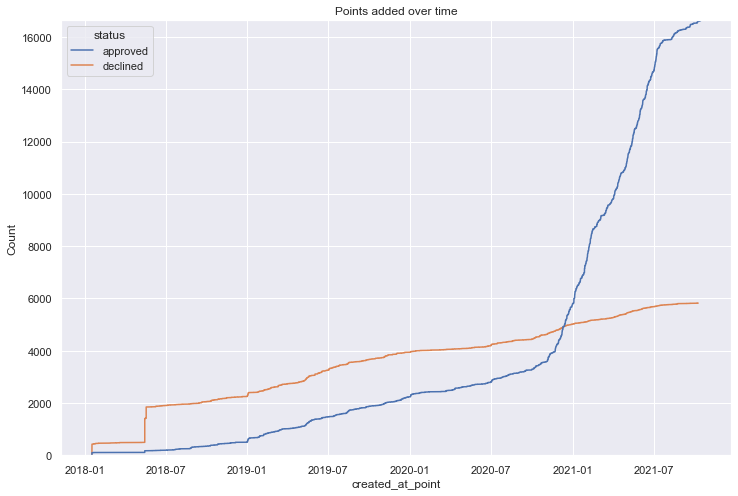

In [37]:
# How have the number of Points grown over time?
plt.figure(figsize=(12,8))
sns.ecdfplot(points, x='created_at_point', hue='status', stat='count')
plt.title('Points added over time')

In [38]:
# To have human readable Service names, join the tables (drop `id` so it's not confusing, since it refers to service id)
points = pd.merge(points, services, left_on='service_id', right_index=True, suffixes=['_point', '_service'])
points = points.drop('id', axis=1)

In [39]:
# For what Services do we have the most Points? What's the distribution of Points-per-Service?
print(f"Points per Service stats:\n{points.service_id.value_counts().describe()}")
points.groupby(['service_id', 'name']).size().sort_values(ascending=False).head(15)

Points per Service stats:
count    1383.000000
mean       16.237166
std        20.961998
min         1.000000
25%         3.000000
50%         9.000000
75%        23.000000
max       338.000000
Name: service_id, dtype: float64


service_id  name              
502         (NONE)                338
182         Facebook              119
194         Reddit                118
536         Discord               114
217         Google                110
230         PayPal                108
1553        Speedtest by Ookla    104
219         Instagram             103
193         LinkedIn              102
198         WhatsApp              101
225         Spotify                99
175         Pinterest              99
200         Twitch                 97
2428        Prezi                  95
280         Tumblr                 95
dtype: int64

In [40]:
# Looking at https://edit.tosdr.org/services/502 (the `(NONE)` service) it appears to be a mix of 
# discussions from a google group, spam, and random deleted Points that I can't place
# Researching that ^ also revealed a `none` Case: https://edit.tosdr.org/cases/235
# It seems to be used when disqualifying Points, and/or linked to random discussions from the google group
# Before removing, inspect. Are any of them approved?
print(cases.loc[235])
points[(points.case_id == 235) & (points.status == 'approved')]

id                                                               235
classification                                               neutral
score                                                              0
title                                                           none
description        Do not select this case, because points with t...
topic_id                                                          53
created_at                                2018-07-11 09:35:12.069597
updated_at                                2019-04-01 07:00:21.112429
privacy_related                                                 None
docbot_regex                                                    None
Name: 235, dtype: object


,id_point,user_id_point,title_point,source,status,analysis,created_at_point,updated_at_point,service_id,quoteText,...,url,created_at,updated_at,wikipedia,keywords,related,slug,is_comprehensively_reviewed,user_id_service,rating
id,,,,,,,,,,,,,,,,,,,,,
1126,1126,7,Instagram may sell your personal information a...,https://help.instagram.com/581066165581870,approved,"Per Instagram's terms: ""If we sell or otherwis...",2018-01-16 21:42:29.693236,2020-12-07 06:46:02.437691,219,<li>Our rights and obligations can be assigned...,...,"instagram.com,help.instagram.com,about.instagr...",2018-01-16 15:26:06.211757,2021-03-25 03:19:31.833924,https://en.wikipedia.org/wiki/Instagram,,,instagram,True,NaN,E


In [41]:
# There also appears to be a `none` Topic, which we can get rid of too

services = services.drop(502)
cases = cases.drop(235)
topics = topics.drop(53)
documents = documents.drop(1378)   # example doc
points = points[(points.service_id != 502) & (points.case_id != 235)]

In [42]:
# What are the distribution of Point counts per Case? What Cases have the most and least approved Points?
print(f"Points per Case stats:\n{points.case_id.value_counts().describe()}\n")
print(points.groupby(['case_id', 'title_case']).size().sort_values(ascending=False).head(15))
points.groupby(['case_id', 'title_case']).size().sort_values(ascending=False).tail(10)

Points per Case stats:
count    245.000000
mean      85.514286
std       92.766435
min        1.000000
25%       25.000000
50%       58.000000
75%      113.000000
max      762.000000
Name: case_id, dtype: float64

case_id  title_case                                                                                                         
331      There is a date of the last update of the agreements                                                                   762
152      This service is only available to users over a certain age                                                             441
286      The service is provided 'as is' and to be used at your sole risk                                                       400
323      You are tracked via web beacons, tracking pixels, browser fingerprinting, and/or device fingerprinting                 360
163      The court of law governing the terms is in location X                                                                  332
1

case_id  title_case                                                            
141      Inconvenient process for obtaining personal data                          4
194      The service does not index or open files that you upload                  4
497      Prices and fees may be changed at any time, without notice to you         3
491      All Traffic is unencrypted (no https)                                     2
212      Pseudonyms are allowed due to the service's billing policies              2
494      An audio version of the Terms of Service is provided                      2
330      The service disables software that you are not licensed to use.           1
495      This service is only available for commercial use                         1
496      You can’t close your account if an investigation is ongoing               1
309      You have the right to request lower Charges from Third Party Providers    1
dtype: int64

In [43]:
# Way above there were some docs without text. Do these have points or can they be dropped?
textless_doc_ids = documents[documents.text.isna()].index
print(f"{len(textless_doc_ids)} docs with missing text")
textless_points = points[points.document_id.isin(textless_doc_ids)]
textless_points

1496 docs with missing text


,id_point,user_id_point,title_point,source,status,analysis,created_at_point,updated_at_point,service_id,quoteText,...,url,created_at,updated_at,wikipedia,keywords,related,slug,is_comprehensively_reviewed,user_id_service,rating
id,,,,,,,,,,,,,,,,,,,,,
6486,6486,1764,You maintain ownership of your data,https://contracts.pixelcatproductions.net/view...,declined,Generated through the annotate view,2019-05-11 21:23:53.858042,2021-02-06 04:16:15.925339,1529,Any content you upload is yours and must be yo...,...,"login.justinback.com,api.justinback.com,partne...",2019-05-05 20:54:08.429393,2021-03-25 03:19:47.911978,,None,None,pixelcat_productions_jbauth,False,1764.0,N/A
6649,6649,1,You waive your right to a class action.,https://forums.pixelcatproductions.net/tos,declined,Generated through the annotate view,2019-05-16 04:45:19.947387,2021-02-06 04:16:27.787786,1529,"You will settle any dispute as an individual, ...",...,"login.justinback.com,api.justinback.com,partne...",2019-05-05 20:54:08.429393,2021-03-25 03:19:47.911978,,None,None,pixelcat_productions_jbauth,False,1764.0,N/A
6391,6391,1764,Your personal data is given to third parties,https://contracts.pixelcatproductions.net/view...,declined,Generated through the annotate view,2019-05-05 21:37:33.260760,2021-02-06 04:02:09.255928,1529,We may employ third party companies and indivi...,...,"login.justinback.com,api.justinback.com,partne...",2019-05-05 20:54:08.429393,2021-03-25 03:19:47.911978,,None,None,pixelcat_productions_jbauth,False,1764.0,N/A
6648,6648,1,The service can delete specific content withou...,https://forums.pixelcatproductions.net/tos,declined,Generated through the annotate view,2019-05-16 04:44:31.505792,2021-02-06 04:16:15.484760,1529,"The company reserves the right to change, reda...",...,"login.justinback.com,api.justinback.com,partne...",2019-05-05 20:54:08.429393,2021-03-25 03:19:47.911978,,None,None,pixelcat_productions_jbauth,False,1764.0,N/A
6491,6491,1764,This service does not track you,https://contracts.pixelcatproductions.net/view...,declined,Generated through the annotate view,2019-05-11 21:32:16.288074,2019-08-01 04:05:15.512556,1529,We don't use any third party tracking software...,...,"login.justinback.com,api.justinback.com,partne...",2019-05-05 20:54:08.429393,2021-03-25 03:19:47.911978,,None,None,pixelcat_productions_jbauth,False,1764.0,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8431,8431,5121,Your personal data is used for limited purposes,https://chatpiserver.mynetgear.com/Privacy.html,declined,Generated through the annotate view,2019-11-21 22:33:24.912840,2021-02-06 04:16:26.110452,2014,This Usage Data may include information such a...,...,"chatpiserver.mynetgear.com,chatpiserver.tk",2019-11-21 22:17:52.248426,2021-03-25 03:19:41.921194,,None,None,chatpiserver,False,5121.0,N/A
8430,8430,5121,This service tracks which web page referred yo...,https://chatpiserver.mynetgear.com/Privacy.html,declined,Generated through the annotate view,2019-11-21 22:31:14.126486,2021-02-06 04:16:26.128977,2014,We use your data to provide and improve the Se...,...,"chatpiserver.mynetgear.com,chatpiserver.tk",2019-11-21 22:17:52.248426,2021-03-25 03:19:41.921194,,None,None,chatpiserver,False,5121.0,N/A
7218,7218,2231,Users are entitled to a refund if certain thre...,https://sunnahosstore-id.com/pages/mailing-and...,declined,Generated through the annotate view,2019-07-02 12:25:59.784839,2021-02-06 04:16:22.908195,1520,All orders are well packed and secured from ca...,...,sunnahosstore-id.com,2019-05-02 15:48:15.063221,2021-04-04 16:15:31.975604,,None,None,sunnah_onestop_store_idbooth_sg,False,NaN,N/A


In [44]:
# What services are these from?
textless_points.name.value_counts()

TunnelBear                                                       43
Pixelcat Productions JBAuth                                      30
Associação de Defesa da Privacidade Digital                      23
Uiiverse                                                         21
TopTree.cc (discontinued?)                                       16
vudu                                                             15
Medtinker                                                        15
Sophos                                                           13
Mailinator                                                       13
nickwasused.com                                                  11
Newegg.com                                                        9
Jagex (including RuneScape)                                       9
Bitcasa (discontinued?)                                           5
EBSCO                                                             5
Travelzoo                                       

In [45]:
# Drop text-less points and docs
points = points.drop(textless_points.index)
documents = documents.drop(textless_doc_ids)

In [46]:
# There are quite a few Points not associated with a doc
print(f"Docless Points: {len(points[points.document_id.isna()])}")
docless_approved = points[(points.status == 'approved') & (points.document_id.isna())]
print(f"Approved docless Points: {len(docless_approved)}")
print(f"Approved docless Points grouped by Case:")
print(docless_approved.groupby(['case_id', 'title_case']).size().sort_values(ascending=False).head(10))
docless_approved.head()
# These probably won't be useful, but for now we'll keep them in the dataset. There may be a way to associate them 
# with docs later and train doc->case classifiers (e.g. "easy to read")
# We can always drop later when forming per-case datasets.

Docless Points: 1365
Approved docless Points: 796
Approved docless Points grouped by Case:
case_id  title_case                                                                                            
199      The terms for this service are easy to read                                                               37
331      There is a date of the last update of the agreements                                                      21
195      You can request access, correction and/or deletion of your data                                           15
163      The court of law governing the terms is in location X                                                     14
193      Your personal data is not sold                                                                            14
128      Third-party cookies are used for advertising                                                              14
140      You can retrieve an archive of your data                                        

,id_point,user_id_point,title_point,source,status,analysis,created_at_point,updated_at_point,service_id,quoteText,...,url,created_at,updated_at,wikipedia,keywords,related,slug,is_comprehensively_reviewed,user_id_service,rating
id,,,,,,,,,,,,,,,,,,,,,
4280,4280,435,easy to read,https://about.qwant.com/legal/privacy/,approved,easy to read,2018-06-09 07:47:42.197731,2018-06-26 08:51:35.009982,527,,...,"qwant.com,qwantjunior.com",2018-06-09 07:31:51.624829,2021-03-25 03:19:36.108592,https://en.wikipedia.org/wiki/Qwant,None,None,qwant,True,NaN,B
4931,4931,1004,The terms for this service are easy to read,https://todoist.com/privacy,approved,,2018-11-01 22:56:15.568223,2020-11-18 16:22:42.336584,809,None,...,todoist.com,2018-11-01 22:41:52.795155,2021-03-25 03:19:38.734350,https://en.wikipedia.org/wiki/Draft:Todoist,None,None,todoist,False,NaN,C
11157,11157,20783,The service provides a complete list of all co...,https://about.deviantart.com/policy/privacy/,approved,"The Privacy Policy states, ""Please check out t...",2020-11-08 22:09:26.198844,2020-11-28 17:09:31.557934,192,None,...,deviantart.com,2018-01-16 15:26:05.686813,2021-05-14 14:37:59.267933,https://en.wikipedia.org/wiki/DeviantArt,,,deviantart,True,NaN,B
6074,6074,395,This service does not force users into binding...,https://observablehq.com/terms-of-service,approved,,2019-03-13 14:01:20.652022,2019-06-23 00:36:08.424787,1447,None,...,observablehq.com,2019-03-13 13:18:15.484146,2021-03-25 03:19:43.912348,,None,None,observable,True,NaN,D
6411,6411,1,You cannot delete your account of this service,https://www.airbnb.com/help/article/240/how-do...,approved,You can not delete your account. You can only ...,2019-05-08 17:34:09.341048,2019-05-12 12:41:27.571265,168,None,...,airbnb.com,2018-01-16 15:26:05.199014,2021-03-25 03:19:24.678569,https://en.wikipedia.org/wiki/Airbnb,,,airbnb,False,NaN,D


/Users/evan/anaconda3/envs/docbot-server/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Quote lengths (num characters)')

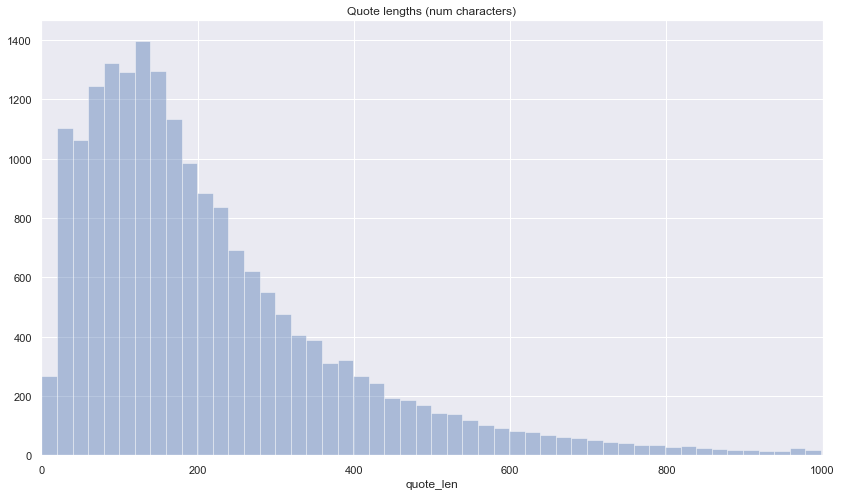

In [47]:
# What is the distribution of quote lengths?
points['quote_len'] = points.quoteEnd - points.quoteStart
fig, ax = plt.subplots(figsize=(14, 8))
ax.set_xlim((0,1000))
sns.distplot(points.quote_len[points.quote_len < 1000], ax=ax, kde=False, norm_hist=False)
plt.title('Quote lengths (num characters)')

In [48]:
# Examine outliers of shortest and largest quotes

# The shortest are probably just a single word or char highlighted out of the relevent sentence.
# We can come back to these when forming per-Case datasets
points.loc[points[points.status == 'approved'].quote_len.sort_values().head(30).index][['quoteText', 'title_case']]

,quoteText,title_case
id,,
21308,None,You can retrieve an archive of your data
21309,None,"You can request access, correction and/or dele..."
21310,None,Some personal data may be kept for business in...
7377,b,There is a date of the last update of the agre...
5583,,The terms for this service are easy to read
12707,IP,"This service may collect, use, and share locat..."
6533,may,There is a date of the last update of the agre...
22825,GDPR,The service claims to be GDPR compliant for Eu...
9312,July,There is a date of the last update of the agre...


In [49]:
# I think most of the longer ones are legitimate, highlighting whole paragraphs around a Case
# I'll probably shorten these by hand when forming per-Case datasets
points.loc[points[points.status == 'approved'].quote_len.sort_values(ascending=False).head(30).index][['quote_len', 'quoteText', 'title_case']]

,quote_len,quoteText,title_case
id,,,
19676,13166.0,"PDATE July 15, 2020:</strong> We have updated ...",The service claims to be CCPA compliant for Ca...
10777,8666.0,Annex 1 <p>\n<b>Purpose of processing</b>\n</p...,Details are provided about what kind of inform...
19758,8609.0,"<p>The following section on CCPA, Cal.\nCiv.\n...",The service claims to be CCPA compliant for Ca...
19757,8569.0,The following sections on GDPR applies to indi...,The service claims to be GDPR compliant for Eu...
20091,7387.0,California Consumer Privacy Act (CCPA) Notice ...,The service claims to be CCPA compliant for Ca...
751,3195.0,Sharing with Third-Party Partners We work with...,This service gives your personal data to third...
10273,3035.0,<strong>Click here</strong> to submit a copyri...,Instructions are provided on how to submit a c...
10108,3003.0,As Qualified asks others to respect its intell...,Instructions are provided on how to submit a c...
1374,2809.0,Here are the types of third parties we share i...,Many third parties are involved in operating t...


In [50]:
# Make sure empty string quoteText is nan
points.quoteText = points.quoteText.replace('', np.nan)

In [51]:
# Join Points with Documents, so we can check the quote contexts. Left join, because we are missing doc IDs for some
points = pd.merge(points, documents, how='left', left_on='document_id', right_index=True, suffixes=['_point', '_doc'])

In [52]:
# All Points associated with a doc have a quoteStart/quoteEnd, but some don't have a quoteText
print(points[(~points.document_id.isna())][['quoteText', 'quoteStart', 'quoteEnd']].info())
points[(~points.document_id.isna()) & points.quoteText.isna()][['title_point', 'status', 'quoteText', 'doc_len', 'quoteStart', 'quoteEnd']]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19321 entries, 4513 to 21774
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   quoteText   19309 non-null  object 
 1   quoteStart  19321 non-null  float64
 2   quoteEnd    19321 non-null  float64
dtypes: float64(2), object(1)
memory usage: 603.8+ KB
None


,title_point,status,quoteText,doc_len,quoteStart,quoteEnd
id,,,,,,
11638,This service does not guarantee that it or the...,approved,None,1600.0,28384.0,28515.0
11630,The service provider makes no warranty regardi...,declined,None,1600.0,28519.0,28600.0
11628,"The service may use tracking pixels, web beaco...",declined,None,1600.0,28519.0,28600.0
8000,This service holds onto content that you've de...,declined,None,13329.0,6863.0,7050.0
8002,The service is provided 'as is' and to be used...,declined,None,13329.0,9326.0,9402.0
13277,The user is informed about security practices,declined,None,2658.0,10337.0,10497.0
14319,You waive your right to a class action.,declined,None,27113.0,78503.0,78673.0
14318,This service does not guarantee that it or the...,declined,None,27113.0,91276.0,91432.0
14321,This service forces users into binding arbitra...,declined,None,27113.0,77916.0,78356.0


In [53]:
# Most docless points don't have a quote at all
print(points[points.document_id.isna()][['quoteText', 'quoteStart', 'quoteEnd']].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1365 entries, 15614 to 25016
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   quoteText   33 non-null     object 
 1   quoteStart  37 non-null     float64
 2   quoteEnd    37 non-null     float64
dtypes: float64(2), object(1)
memory usage: 42.7+ KB
None


In [54]:
# To be safe lets drop Points with quoteStart but no quoteText as anomolies
points = points.drop(points[(~points.quoteStart.isna()) & points.quoteText.isna()].index)
len(points)

20670

In [55]:
# Sanity check -- there should never be a case where a quote ends after the length of the Doc
# Uhoh, my guess is the Doc was updated after the fact
sum(points.doc_len < points.quoteEnd)

410

In [56]:
# Does quoteText match the document text from quoteStart to quoteEnd?
for i, point in points[~points.quoteStart.isna()].sample(10).iterrows():
    print(point.quoteText)
    print(point.text[int(point.quoteStart):int(point.quoteEnd)])
    print("=" * 30)

Like many companies, we use cookies (small text files placed on your computer or device) and other tracking technologies on the Services (referred to together from this point forward as “Cookies”, unless otherwise stated) including HTTP cookies, HTML5 and Flash local storage/ flash cookies, web beacons/GIFs, embedded scripts, ETags/cache browsers, and software development kits.
Like many companies, we use cookies (small text files placed on your computer or device) and other tracking technologies on the Services (referred to together from this point forward as “Cookies”, unless otherwise stated) including HTTP cookies, HTML5 and Flash local storage/ flash cookies, web beacons/GIFs, embedded scripts, ETags/cache browsers, and software development kits.
Policy published 11 September 2020.</p>
Policy published 11 September 2020.</p>
 Please recognize that protecting your Personal Information is also your responsibility.
We ask you to be responsible for safeguarding your password, and othe

In [57]:
# Some of these match, others don't. Lets get a count.
points['quoteTextExtracted'] = points.apply(lambda point: point.text[int(point.quoteStart):int(point.quoteEnd)] if not (np.isnan(point.quoteStart) or pd.isnull(point.text)) else np.NaN, axis=1)
mismatching_quotes = points[(~points.quoteStart.isna()) & (points.quoteText != points.quoteTextExtracted)]
print(f"{len(mismatching_quotes)} extracted quotes don't match quoteText")
mismatching_quotes.sample(10)[['quoteText', 'quoteTextExtracted', 'id_doc', 'quoteStart', 'quoteEnd', 'service_id_point']]
# Yikes, that's a lot of mismatches. Since quoteTextExtracted doesn't respect sentence boundaries, this is surely because
# docs were updated but not aligned to reset quoteStart and quoteEnd.

2987 extracted quotes don't match quoteText


,quoteText,quoteTextExtracted,id_doc,quoteStart,quoteEnd,service_id_point
id,,,,,,
8669,Data retention<p>We are a regulated Financial ...,"with its efforts to combat fraud, illegal act...",594.0,9378.0,9685.0,470
7604,Any failure of Forbes to enforce or exercise a...,ch claim or cause of action is barred.\nAny fa...,1380.0,29056.0,29207.0,1577
5347,Course Hero is also free to terminate (or susp...,,875.0,26325.0,26622.0,1038
10079,3.Changes to the Terms<p>We amend these Terms ...,,1093.0,3164.0,4006.0,1448
4951,"<strong>Last Updated</strong>: May 30, 2018</p>",,301.0,23568.0,23615.0,1336
9932,NOR DO THEY MAKE ANY WARRANTY AS TO THE RESULT...,OR ANY OTHER THIRD PARTIES.IF APPLICABLE LAW D...,186.0,21478.0,21685.0,318
708,The user is obliged\n</p>\n<p>\n(a) to provide...,refrain from engaging in any of the following ...,212.0,16291.0,16451.0,241
11809,"<p>We may use your Identity, Contact, Technica...",from us or purchased services from us or if y...,1003.0,12555.0,12828.0,1386
6608,We reserve the right to change this Online Pri...,out you through our Services.\nYou may have th...,1281.0,18144.0,18214.0,1548


In [58]:
# In order to form per-Case classification datasets and build effective models, we need to know the original context 
# for the quote. We could just discard these, but it would be nice to keep the datasets as large as possible.
# First, lets see if the out-of-date docs were kept and just marked `deleted`
documents_orig = pickle.load(open(f'../data/documents_{VERSION}.pkl', 'rb'))
documents_orig.loc[mismatching_quotes.id_doc.dropna()].status.value_counts()

Series([], Name: status, dtype: int64)

In [59]:
# That's a no. The next best option is to see if we can find the original quote text in the new doc.
# I wouldn't trust being able to place a quote that is found multiple times in the doc (especially given the 
# really short ones shown previously) but we can change quoteStart/quoteEnd if it's found once
points['quoteStartOrig'] = points.quoteStart.copy()
points['quoteEndOrig'] = points.quoteEnd.copy()
for i, point in mismatching_quotes.iterrows():
    if np.isnan(point.id_doc) or np.isnan(point.quoteStart):
        continue
    n_matches = point.text.count(point.quoteText)
    points.at[i,'n_quote_matches'] = n_matches
    if n_matches == 1:
        new_start = point.text.find(point.quoteText)
        points.at[i,'quoteStart'] = new_start
        points.at[i,'quoteEnd'] = new_start + len(point.quoteText)
print(points.loc[mismatching_quotes.index].n_quote_matches.describe())
print(f"{sum(points.quoteStart != points.quoteStartOrig)} updated or NaN")

count    2954.000000
mean        0.436696
std         1.796134
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        61.000000
Name: n_quote_matches, dtype: float64
2312 updated or NaN


In [60]:
# A little better, but still missing a ton
points['quoteTextExtracted'] = points.apply(lambda point: point.text[int(point.quoteStart):int(point.quoteEnd)] if not (np.isnan(point.quoteStart) or pd.isnull(point.text)) else np.NaN, axis=1)
mismatching_quotes = points[(~points.quoteStart.isna()) & (points.quoteText != points.quoteTextExtracted)]
print(f"{len(mismatching_quotes)} extracted quotes don't match quoteText")
print(mismatching_quotes.status.value_counts())

2003 extracted quotes don't match quoteText
declined    1837
approved     166
Name: status, dtype: int64


In [61]:
# That's as far as we'll go for now. We can always find a way to do whitespace-invarient comparison later.
# Remove the mismatched quotes. Given the `if n_matches == 1` above, this should filter out 0 or 2+ matches
points = points[(points.quoteText == points.quoteTextExtracted) | (points.quoteStart.isna())]
points = points.drop(['quoteTextExtracted', 'quoteStartOrig', 'quoteEndOrig'], axis=1)

In [62]:
# Points by language, since we didn't inspect it earlier
points.lang.value_counts()

en       16144
fr         562
es         163
zh-cn      154
de         137
nl          36
ru          30
tr          20
it          19
pt          18
ro          16
ko          12
cs           7
ja           5
et           5
hu           4
el           4
ca           2
da           1
Name: lang, dtype: int64

In [63]:
# One last sanity check: are there dangling foreign keys?
assert(len(set(documents.service_id) - set(services.index)) == 0)
assert(len(set(cases.topic_id) - set(topics.index)) == 0)
assert(len(set(points.service_id_point) - set(services.index)) == 0)
assert(len(set(points.case_id) - set(cases.index)) == 0)
assert(len(set(points.document_id.dropna()) - set(documents.index)) == 0)

In [64]:
# At this point, the datasets should be mostly clean (aside from some Points that don't reference Docs)
# There are some columns we need to drop/rename due to joins, and then we'll re-save
services.to_pickle(f'../data/services_{VERSION}_clean.pkl')

In [68]:
documents_orig = pickle.load(open(f'../data/documents_{VERSION}.pkl', 'rb'))
documents = documents[documents.columns[:13]]
documents = documents.rename({'id_doc': 'id', 'name_doc': 'name', 'url_doc': 'url', 'created_at_doc': 'created_at',
                                 'updated_at_doc': 'updated_at', 'user_id_doc': 'user_id'}, axis=1)
# Make sure columns names match original (but we're fine with dropped status, as we got rid of all `deleted` ones)
documents_orig = documents_orig.drop('status', axis=1)
documents.to_pickle(f'../data/documents_{VERSION}_clean.pkl')

In [69]:
topics.to_pickle(f'../data/topics_{VERSION}_clean.pkl')

In [70]:
cases.to_pickle(f'../data/cases_{VERSION}_clean.pkl')

In [80]:
points_orig = pickle.load(open(f'../data/points_{VERSION}.pkl', 'rb'))
points = points[points.columns[:16].tolist() + ['lang']]  # Keep lang because it's a little expensive to compute
points = points.rename({'id_point': 'id', 'user_id_point': 'user_id', 'title_point': 'title', 'created_at_point': 'created_at',
                                 'updated_at_point': 'updated_at', 'service_id_point': 'service_id'}, axis=1)
# Make sure columns names match original
points_orig = points_orig.drop(['oldId', 'rank'], axis=1)
points.to_pickle(f'../data/points_{VERSION}_clean.pkl')